## Trains an agent to play pong using the REINFORCE algorithm

In [1]:
# import dependencies

import gym
import time
import pong_utils
import matplotlib
import matplotlib.pyplot as plt
import pong_utils

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

# for displaying animation
!pip install JSAnimation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# create pong environment

env = gym.make('PongDeterministic-v4')
print("List of available actions: ", env.unwrapped.get_action_meanings())

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


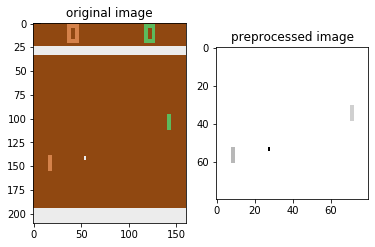

In [3]:
# display images
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

# original image
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

# preprocessed image
plt.subplot(1,2,2)
plt.title('preprocessed image')
# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')

In [4]:
# defining the policy

# the output is the probability of moving right
# where P(left) = 1-P(right)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        # new_size = (size - kernel_size)/stride + 1, i.e. (80 - 6)/2 + 1 = 38
      
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        # new_size = (size - kernel_size)/stride + 1, i.e. (38 - 6)/4 + 1 = 9
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        self.fc1 = nn.Linear(self.size, 512)
        self.fc2 = nn.Linear(512, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return self.sig(x)

policy = pong_utils.Policy().to(device)

In [5]:
# optimize model
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

In [6]:
# add preprocessing stage and visualize the game
pong_utils.play(env, policy, time=2000, preprocess=None, nrand=5) 
print (fanim)

TypeError: a bytes-like object is required, not 'str'

In [ ]:
# collect multiple samples from parrallelized environments
from parallelEnv import parallelEnv 
envs = parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

print(reward)

In [ ]:
# Defining surrogate fuction for training

LSUR = pong_utils.surrogate(policy, prob, state, action, reward)
print(LSUR)

In [ ]:
# Training the agent

from parallelEnv import parallelEnv
import numpy as np

episode = 1000
! pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .01
tmax = 320

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    
    L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

In [ ]:
# visualize game after training
pong_utils.play(env, policy, time=2000) 
plt.plot(mean_rewards)

In [ ]:
# save policy
torch.save(policy, 'REINFORCE.policy')

In [ ]:
# load and test policy
policy = torch.load('REINFORCE.policy')